## 1.Creation of context

### Loading the required libraries

In [76]:
%matplotlib inline
import pyspark
from os import listdir
from os.path import isfile, join
import boto3
import pandas as pd
from sagemaker import get_execution_role
from pyspark.sql.types import LongType, StringType, StructField, StructType, BooleanType, ArrayType, IntegerType
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql.functions import col
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

### Creating requisite contexts to connect to spark

In [2]:
config = pyspark.SparkConf().setAppName('odl').setMaster('local')
spcon = pyspark.SparkContext(conf=config)
sqlcon = pyspark.sql.SQLContext(spcon)
spcon

<SparkContext master=local appName=odl>

In [3]:
sqlcon

## 2.Preparation of data (parquet)

### Connecting to S3 bucket and loading file into pandas dataframe

In [4]:
bucket='odl-spark19spds6003-001'
data_key = 'as3uj/heart.csv'
data_location = 's3://{}/{}'.format(bucket, data_key)
pd.read_csv(data_location)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [5]:
heart_df = sqlcon.createDataFrame(pd.read_csv(data_location))
heart_df

DataFrame[age: bigint, sex: bigint, cp: bigint, trestbps: bigint, chol: bigint, fbs: bigint, restecg: bigint, thalach: bigint, exang: bigint, oldpeak: double, slope: bigint, ca: bigint, thal: bigint, target: bigint]

### Writing the heart data to a parquet path

In [6]:
parquetPath = '/home/ec2-user/SageMaker/as3uj/heart_pqt'
heart_df.write.parquet(parquetPath)

### Write to spark dataframe from parquet

In [7]:
heart_spdf = sqlcon.read.parquet(parquetPath)
heart_spdf

DataFrame[age: bigint, sex: bigint, cp: bigint, trestbps: bigint, chol: bigint, fbs: bigint, restecg: bigint, thalach: bigint, exang: bigint, oldpeak: double, slope: bigint, ca: bigint, thal: bigint, target: bigint]

In [8]:
heart_spdf.printSchema()

root
 |-- age: long (nullable = true)
 |-- sex: long (nullable = true)
 |-- cp: long (nullable = true)
 |-- trestbps: long (nullable = true)
 |-- chol: long (nullable = true)
 |-- fbs: long (nullable = true)
 |-- restecg: long (nullable = true)
 |-- thalach: long (nullable = true)
 |-- exang: long (nullable = true)
 |-- oldpeak: double (nullable = true)
 |-- slope: long (nullable = true)
 |-- ca: long (nullable = true)
 |-- thal: long (nullable = true)
 |-- target: long (nullable = true)



## 3.MLlib based analysis

In [9]:
heart_spdf.head(5)

[Row(age=63, sex=1, cp=3, trestbps=145, chol=233, fbs=1, restecg=0, thalach=150, exang=0, oldpeak=2.3, slope=0, ca=0, thal=1, target=1),
 Row(age=37, sex=1, cp=2, trestbps=130, chol=250, fbs=0, restecg=1, thalach=187, exang=0, oldpeak=3.5, slope=0, ca=0, thal=2, target=1),
 Row(age=41, sex=0, cp=1, trestbps=130, chol=204, fbs=0, restecg=0, thalach=172, exang=0, oldpeak=1.4, slope=2, ca=0, thal=2, target=1),
 Row(age=56, sex=1, cp=1, trestbps=120, chol=236, fbs=0, restecg=1, thalach=178, exang=0, oldpeak=0.8, slope=2, ca=0, thal=2, target=1),
 Row(age=57, sex=0, cp=0, trestbps=120, chol=354, fbs=0, restecg=1, thalach=163, exang=1, oldpeak=0.6, slope=2, ca=0, thal=2, target=1)]

In [10]:
heart_spdf.describe('target').show()

+-------+------------------+
|summary|            target|
+-------+------------------+
|  count|               303|
|   mean|0.5445544554455446|
| stddev|0.4988347841643915|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [11]:
heart_spdf.groupby('target').count().show()

+------+-----+
|target|count|
+------+-----+
|     0|  138|
|     1|  165|
+------+-----+



### Dividing the data into train and test(with same target label proportions)

In [12]:
heart_0 = heart_spdf.filter(heart_spdf.target == 0)

In [13]:
heart_0.head(5)

[Row(age=67, sex=1, cp=0, trestbps=160, chol=286, fbs=0, restecg=0, thalach=108, exang=1, oldpeak=1.5, slope=1, ca=3, thal=2, target=0),
 Row(age=67, sex=1, cp=0, trestbps=120, chol=229, fbs=0, restecg=0, thalach=129, exang=1, oldpeak=2.6, slope=1, ca=2, thal=3, target=0),
 Row(age=62, sex=0, cp=0, trestbps=140, chol=268, fbs=0, restecg=0, thalach=160, exang=0, oldpeak=3.6, slope=0, ca=2, thal=2, target=0),
 Row(age=63, sex=1, cp=0, trestbps=130, chol=254, fbs=0, restecg=0, thalach=147, exang=0, oldpeak=1.4, slope=1, ca=1, thal=3, target=0),
 Row(age=53, sex=1, cp=0, trestbps=140, chol=203, fbs=1, restecg=0, thalach=155, exang=1, oldpeak=3.1, slope=0, ca=0, thal=3, target=0)]

In [14]:
heart_1 = heart_spdf.filter(heart_spdf.target == 1)

In [15]:
heart_1.head(5)

[Row(age=63, sex=1, cp=3, trestbps=145, chol=233, fbs=1, restecg=0, thalach=150, exang=0, oldpeak=2.3, slope=0, ca=0, thal=1, target=1),
 Row(age=37, sex=1, cp=2, trestbps=130, chol=250, fbs=0, restecg=1, thalach=187, exang=0, oldpeak=3.5, slope=0, ca=0, thal=2, target=1),
 Row(age=41, sex=0, cp=1, trestbps=130, chol=204, fbs=0, restecg=0, thalach=172, exang=0, oldpeak=1.4, slope=2, ca=0, thal=2, target=1),
 Row(age=56, sex=1, cp=1, trestbps=120, chol=236, fbs=0, restecg=1, thalach=178, exang=0, oldpeak=0.8, slope=2, ca=0, thal=2, target=1),
 Row(age=57, sex=0, cp=0, trestbps=120, chol=354, fbs=0, restecg=1, thalach=163, exang=1, oldpeak=0.6, slope=2, ca=0, thal=2, target=1)]

In [16]:
seed = 7
(heart_0test, heart_0train) = heart_0.randomSplit((0.20, 0.80), seed=seed)
(heart_1test, heart_1train) = heart_1.randomSplit((0.20, 0.80), seed=seed)

In [17]:
print ('training set with target 0 = {}, test set with target 0 = {}'.format(heart_0train.count(),heart_0test.count()))

training set with target 0 = 111, test set with target 0 = 27


In [18]:
print ('training set with target 1 = {}, test set with target 1 = {}'.format(heart_1train.count(),heart_1test.count()))

training set with target 1 = 134, test set with target 1 = 31


In [19]:
heart_train = heart_1train.union(heart_0train)
heart_test = heart_1test.union(heart_0test)

In [20]:
heart_train.describe('target').show()

+-------+------------------+
|summary|            target|
+-------+------------------+
|  count|               245|
|   mean|0.5469387755102041|
| stddev|0.4988108978460373|
|    min|                 0|
|    max|                 1|
+-------+------------------+



In [21]:
heart_test.describe('target').show()

+-------+------------------+
|summary|            target|
+-------+------------------+
|  count|                58|
|   mean|0.5344827586206896|
| stddev|0.5031660198753178|
|    min|                 0|
|    max|                 1|
+-------+------------------+



### Vectorization

In [22]:
ignore = ['target']
assembler = VectorAssembler(
    inputCols=[x for x in heart_train.columns if x not in ignore],
    outputCol='features')

In [23]:
heart_train = assembler.transform(heart_train)

In [24]:
heart_train

DataFrame[age: bigint, sex: bigint, cp: bigint, trestbps: bigint, chol: bigint, fbs: bigint, restecg: bigint, thalach: bigint, exang: bigint, oldpeak: double, slope: bigint, ca: bigint, thal: bigint, target: bigint, features: vector]

In [25]:
heart_test = assembler.transform(heart_test)

In [26]:
heart_test

DataFrame[age: bigint, sex: bigint, cp: bigint, trestbps: bigint, chol: bigint, fbs: bigint, restecg: bigint, thalach: bigint, exang: bigint, oldpeak: double, slope: bigint, ca: bigint, thal: bigint, target: bigint, features: vector]

In [27]:
trainingDF = heart_train.selectExpr("target","features")
testDF = heart_test.selectExpr("target","features")

In [28]:
trainingDF = trainingDF.withColumnRenamed("target","label")
testDF = testDF.withColumnRenamed("target","label")

In [29]:
trainingDF

DataFrame[label: bigint, features: vector]

In [30]:
trainingDF.head(245)

[Row(label=1, features=DenseVector([29.0, 1.0, 1.0, 130.0, 204.0, 0.0, 0.0, 202.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([34.0, 1.0, 3.0, 118.0, 182.0, 0.0, 0.0, 174.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([35.0, 0.0, 0.0, 138.0, 183.0, 0.0, 1.0, 182.0, 0.0, 1.4, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([35.0, 1.0, 1.0, 122.0, 192.0, 0.0, 1.0, 174.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([37.0, 0.0, 2.0, 120.0, 215.0, 0.0, 1.0, 170.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([37.0, 1.0, 2.0, 130.0, 250.0, 0.0, 1.0, 187.0, 0.0, 3.5, 0.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([38.0, 1.0, 2.0, 138.0, 175.0, 0.0, 1.0, 173.0, 0.0, 0.0, 2.0, 4.0, 2.0])),
 Row(label=1, features=DenseVector([39.0, 0.0, 2.0, 94.0, 199.0, 0.0, 1.0, 179.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([39.0, 0.0, 2.0, 138.0, 220.0, 0.0, 1.0, 152.0, 0.0, 0.0, 1.0, 0.0, 2.0])),
 R

In [31]:
testDF

DataFrame[label: bigint, features: vector]

In [32]:
testDF.head(58)

[Row(label=1, features=DenseVector([34.0, 0.0, 1.0, 118.0, 210.0, 0.0, 1.0, 192.0, 0.0, 0.7, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([38.0, 1.0, 2.0, 138.0, 175.0, 0.0, 1.0, 173.0, 0.0, 0.0, 2.0, 4.0, 2.0])),
 Row(label=1, features=DenseVector([41.0, 1.0, 2.0, 112.0, 250.0, 0.0, 1.0, 179.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([43.0, 1.0, 0.0, 150.0, 247.0, 0.0, 1.0, 171.0, 0.0, 1.5, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([44.0, 1.0, 1.0, 120.0, 220.0, 0.0, 1.0, 170.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([44.0, 1.0, 2.0, 130.0, 233.0, 0.0, 1.0, 179.0, 1.0, 0.4, 2.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([45.0, 1.0, 0.0, 104.0, 208.0, 0.0, 0.0, 148.0, 1.0, 3.0, 1.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([46.0, 0.0, 2.0, 142.0, 177.0, 0.0, 0.0, 160.0, 1.0, 1.4, 0.0, 0.0, 2.0])),
 Row(label=1, features=DenseVector([47.0, 1.0, 2.0, 138.0, 257.0, 0.0, 0.0, 156.0, 0.0, 0.0, 2.0, 0.0, 2.0])),
 

### Classification using logistic regression

In [33]:
lrModel = LogisticRegression().fit(trainingDF)

In [34]:
predictions = lrModel.transform(testDF)

In [35]:
display(predictions)

DataFrame[label: bigint, features: vector, rawPrediction: vector, probability: vector, prediction: double]

In [36]:
print(predictions.orderBy(predictions.label.desc()).take(5))

[Row(label=1, features=DenseVector([34.0, 0.0, 1.0, 118.0, 210.0, 0.0, 1.0, 192.0, 0.0, 0.7, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([-4.7075, 4.7075]), probability=DenseVector([0.0089, 0.9911]), prediction=1.0), Row(label=1, features=DenseVector([38.0, 1.0, 2.0, 138.0, 175.0, 0.0, 1.0, 173.0, 0.0, 0.0, 2.0, 4.0, 2.0]), rawPrediction=DenseVector([-0.2034, 0.2034]), probability=DenseVector([0.4493, 0.5507]), prediction=1.0), Row(label=1, features=DenseVector([41.0, 1.0, 2.0, 112.0, 250.0, 0.0, 1.0, 179.0, 0.0, 0.0, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([-4.3948, 4.3948]), probability=DenseVector([0.0122, 0.9878]), prediction=1.0), Row(label=1, features=DenseVector([43.0, 1.0, 0.0, 150.0, 247.0, 0.0, 1.0, 171.0, 0.0, 1.5, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([0.3481, -0.3481]), probability=DenseVector([0.5862, 0.4138]), prediction=0.0), Row(label=1, features=DenseVector([44.0, 1.0, 1.0, 120.0, 220.0, 0.0, 1.0, 170.0, 0.0, 0.0, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([-2.

### Evaluation (AUC) for logistic regression

In [37]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8088410991636799

### Classification with Random Forest

In [38]:
rf = RandomForestClassifier(labelCol="label", featuresCol="features")
rfModel = rf.fit(trainingDF)

In [39]:
predictions_rf = rfModel.transform(testDF)

In [40]:
predictions_rf.printSchema()

root
 |-- label: long (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)



In [41]:
print(predictions_rf.orderBy(predictions_rf.label.desc()).take(5))

[Row(label=1, features=DenseVector([34.0, 0.0, 1.0, 118.0, 210.0, 0.0, 1.0, 192.0, 0.0, 0.7, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([0.1313, 19.8687]), probability=DenseVector([0.0066, 0.9934]), prediction=1.0), Row(label=1, features=DenseVector([38.0, 1.0, 2.0, 138.0, 175.0, 0.0, 1.0, 173.0, 0.0, 0.0, 2.0, 4.0, 2.0]), rawPrediction=DenseVector([1.393, 18.607]), probability=DenseVector([0.0696, 0.9304]), prediction=1.0), Row(label=1, features=DenseVector([41.0, 1.0, 2.0, 112.0, 250.0, 0.0, 1.0, 179.0, 0.0, 0.0, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([0.5293, 19.4707]), probability=DenseVector([0.0265, 0.9735]), prediction=1.0), Row(label=1, features=DenseVector([43.0, 1.0, 0.0, 150.0, 247.0, 0.0, 1.0, 171.0, 0.0, 1.5, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([4.2286, 15.7714]), probability=DenseVector([0.2114, 0.7886]), prediction=1.0), Row(label=1, features=DenseVector([44.0, 1.0, 1.0, 120.0, 220.0, 0.0, 1.0, 170.0, 0.0, 0.0, 2.0, 0.0, 2.0]), rawPrediction=DenseVector([0.684

### Evaluation (AUC) for random forest

In [64]:
evaluator_rf = BinaryClassificationEvaluator()
evaluator_rf.evaluate(predictions_rf)

0.8375149342891279

### 4. Visualization  

#### ROC for Logistic Regression and Random Forest models

In [78]:
results = predictions.select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

In [79]:
fpr_lr = dict()
tpr_lr = dict()
roc_auc_lr = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_score)
roc_auc_lr = auc(fpr_lr, tpr_lr)

In [80]:
roc_auc_lr

0.8088410991636797

In [72]:
results = predictions_rf.select(['probability', 'label'])
results_collect = results.collect()
results_list = [(float(i[0][0]), 1.0-float(i[1])) for i in results_collect]

In [73]:
fpr_rf = dict()
tpr_rf = dict()
roc_auc_rf = dict()
 
y_test = [i[1] for i in results_list]
y_score = [i[0] for i in results_list]
 
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_score)
roc_auc_rf = auc(fpr_rf, tpr_rf)

In [88]:
y_score

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [77]:
roc_auc_rf

0.8375149342891278

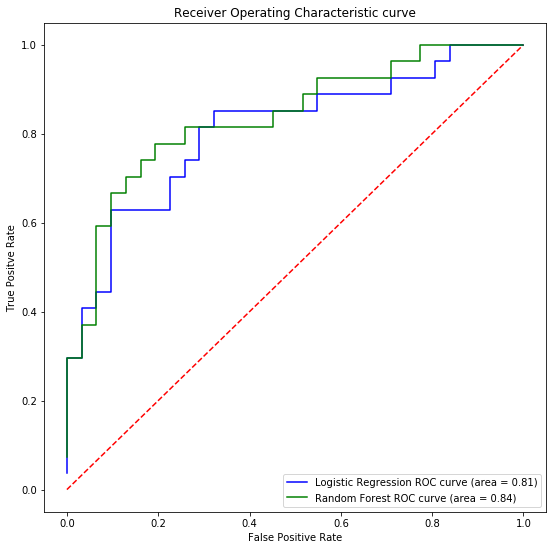

In [84]:
plt.figure(figsize=(9,9))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(fpr_lr, tpr_lr, 'b' ,label='Logistic Regression ROC curve (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_rf, tpr_rf, 'g' ,label='Random Forest ROC curve (area = %0.2f)' % roc_auc_rf)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.title('Receiver Operating Characteristic curve')
plt.legend(loc="lower right")
plt.show()